# 01 - Surrogate Functions

This notebook visualizes the biological surrogate functions used in the tree growth simulation.

All functions are smooth and differentiable, designed to approximate biological processes
while maintaining gradient flow for optimization.

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from sim import surrogates

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## 1. Saturation Function (Michaelis-Menten)

The saturation function models diminishing returns:

$$f(x) = \frac{x}{x + K}$$

Properties:
- $f(0) = 0$
- $f(K) = 0.5$ (half-saturation)
- $f(\infty) \to 1$

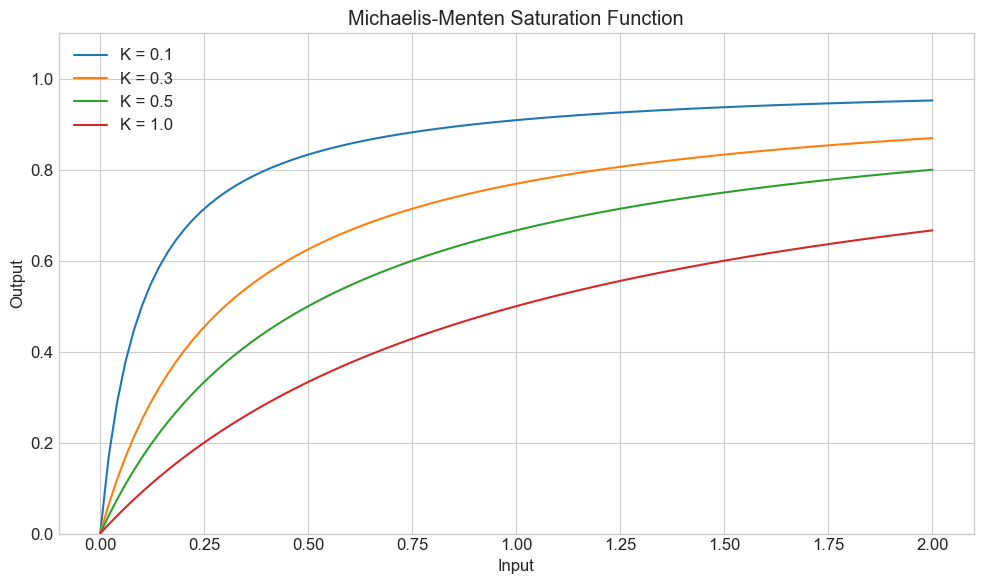

In [2]:
x = jnp.linspace(0, 2, 100)

fig, ax = plt.subplots()
for k in [0.1, 0.3, 0.5, 1.0]:
    y = surrogates.saturation(x, k=k)
    ax.plot(x, y, label=f'K = {k}')

ax.set_xlabel('Input')
ax.set_ylabel('Output')
ax.set_title('Michaelis-Menten Saturation Function')
ax.legend()
ax.set_ylim(0, 1.1)
plt.tight_layout()
plt.show()

## 2. Temperature Window

The temperature efficiency window uses a double sigmoid:

$$f(T) = \sigma(k(T - T_{min})) \cdot \sigma(k(T_{max} - T))$$

This creates a soft "between" gate that's high in the optimal range and low outside.

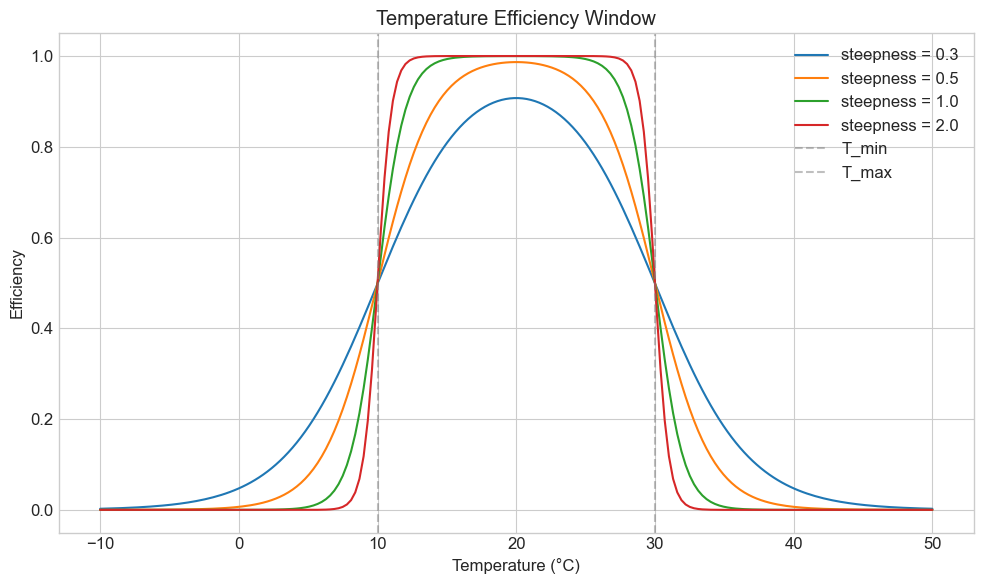

In [3]:
temps = jnp.linspace(-10, 50, 200)

fig, ax = plt.subplots()
for steepness in [0.3, 0.5, 1.0, 2.0]:
    y = surrogates.temperature_window(temps, t_min=10, t_max=30, steepness=steepness)
    ax.plot(temps, y, label=f'steepness = {steepness}')

ax.axvline(10, color='gray', linestyle='--', alpha=0.5, label='T_min')
ax.axvline(30, color='gray', linestyle='--', alpha=0.5, label='T_max')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Efficiency')
ax.set_title('Temperature Efficiency Window')
ax.legend()
plt.tight_layout()
plt.show()

## 3. Wind Damage

Wind damage uses a sigmoid centered at the threshold:

$$d(v) = \sigma(k(v - v_0))$$

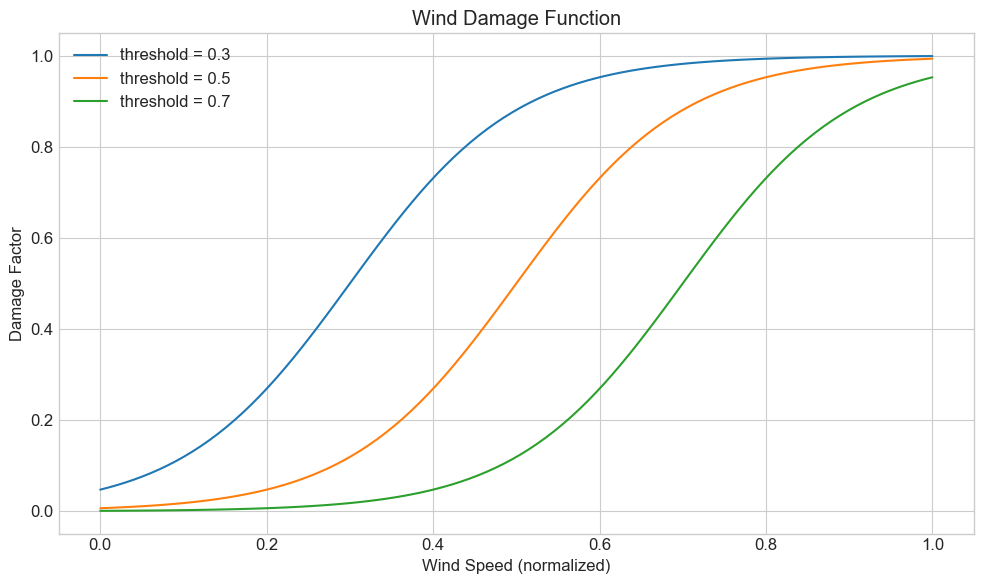

In [4]:
wind = jnp.linspace(0, 1, 100)

fig, ax = plt.subplots()
for threshold in [0.3, 0.5, 0.7]:
    y = surrogates.wind_damage(wind, threshold=threshold, steepness=10.0)
    ax.plot(wind, y, label=f'threshold = {threshold}')

ax.set_xlabel('Wind Speed (normalized)')
ax.set_ylabel('Damage Factor')
ax.set_title('Wind Damage Function')
ax.legend()
plt.tight_layout()
plt.show()

## 4. Structural Penalty

The structural penalty uses baseline-subtracted softplus:

$$\text{penalty}(l, c) = \text{softplus}(l - c) - \text{softplus}(-c)$$

This ensures **penalty = 0 at load = 0** (avoiding an always-on energy tax), while still penalizing unsupported canopy mass.

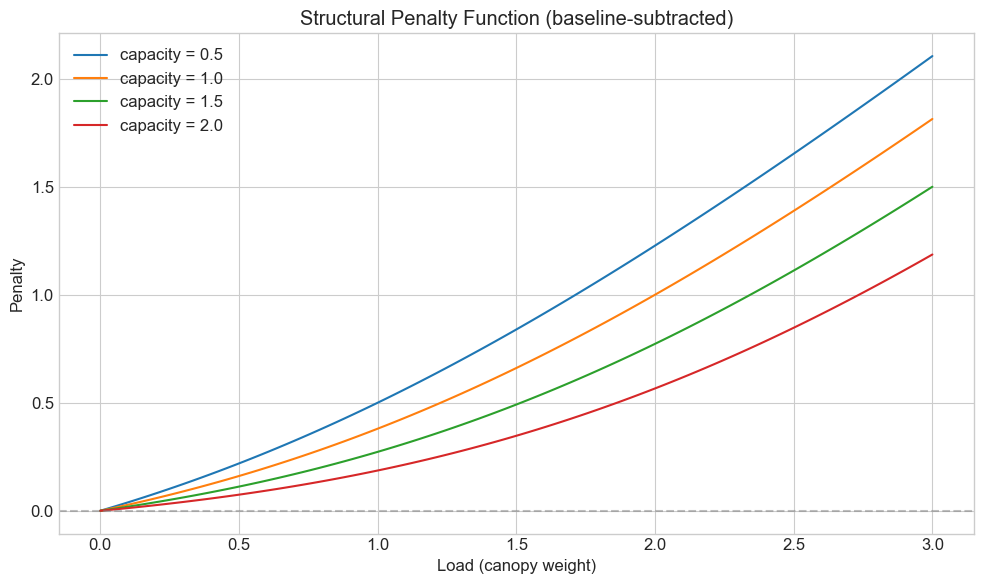

Verification - penalty at load=0:
  capacity=0.5: penalty=0.000000
  capacity=1.0: penalty=0.000000
  capacity=2.0: penalty=0.000000


In [5]:
# Vectorized: use jax.vmap for efficient computation
from functools import partial
import jax

loads = jnp.linspace(0, 3, 100)

fig, ax = plt.subplots()
for capacity in [0.5, 1.0, 1.5, 2.0]:
    # Vectorize over loads with fixed capacity
    penalty_fn = partial(surrogates.structural_penalty, capacity=capacity)
    penalties = jax.vmap(penalty_fn)(loads)
    ax.plot(loads, penalties, label=f'capacity = {capacity}')

ax.set_xlabel('Load (canopy weight)')
ax.set_ylabel('Penalty')
ax.set_title('Structural Penalty Function (baseline-subtracted)')
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

# Verify penalty(0, c) = 0
print("Verification - penalty at load=0:")
for c in [0.5, 1.0, 2.0]:
    p = surrogates.structural_penalty(0.0, c)
    print(f"  capacity={c}: penalty={float(p):.6f}")

## 5. Photosynthesis

Photosynthesis combines multiple limiting factors:

$$P = L \cdot P_{max} \cdot f_I(I) \cdot f_W(W) \cdot f_N(N)$$

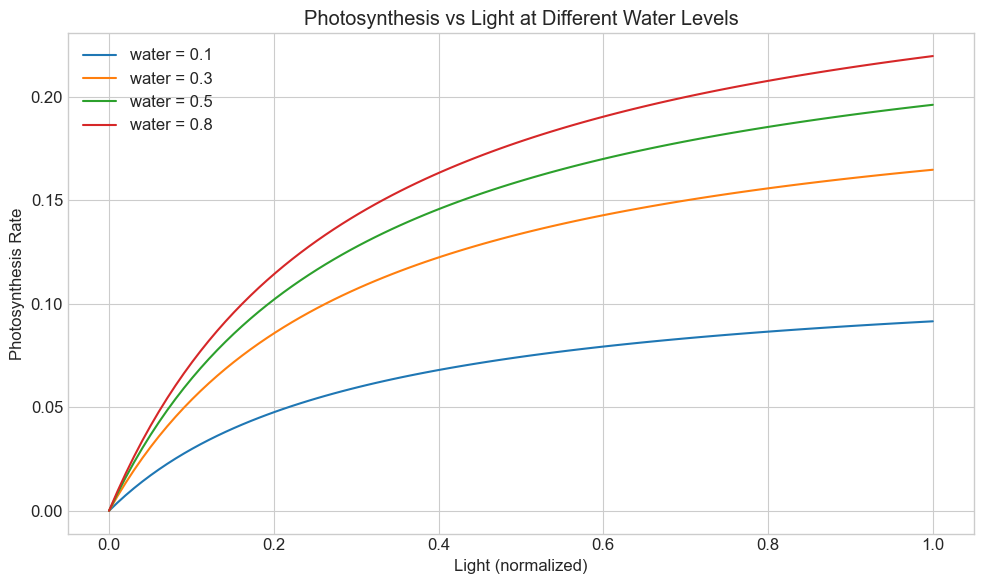

In [6]:
# Vectorized photosynthesis computation
light = jnp.linspace(0, 1, 100)

fig, ax = plt.subplots()
for water in [0.1, 0.3, 0.5, 0.8]:
    # Vectorize: photosynthesis is already array-compatible
    photo = surrogates.photosynthesis(
        leaves=jnp.ones_like(light),  # Broadcast leaves=1.0
        light=light,
        water=jnp.full_like(light, water),
        nutrients=jnp.full_like(light, 0.5),
        p_max=0.5,
        k_light=0.3,
        k_water=0.2,
        k_nutrient=0.2,
    )
    ax.plot(light, photo, label=f'water = {water}')

ax.set_xlabel('Light (normalized)')
ax.set_ylabel('Photosynthesis Rate')
ax.set_title('Photosynthesis vs Light at Different Water Levels')
ax.legend()
plt.tight_layout()
plt.show()

## 6. Root Uptake

Root uptake of water and nutrients depends on root biomass and soil moisture.

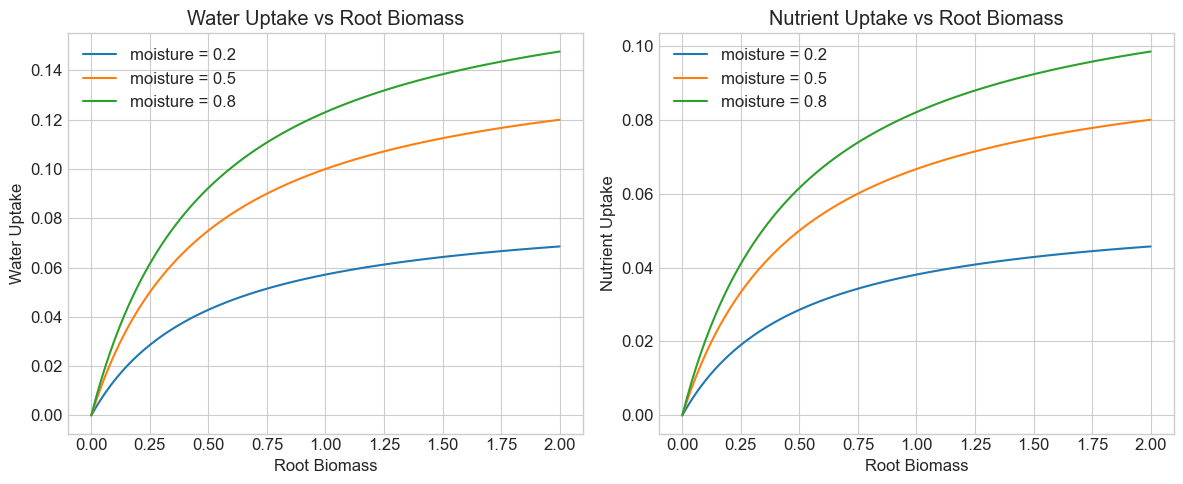

In [7]:
# Vectorized root uptake computation
roots = jnp.linspace(0, 2, 100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for moisture in [0.2, 0.5, 0.8]:
    # root_uptake is already vectorizable
    water_uptake, nutrient_uptake = surrogates.root_uptake(
        roots=roots,
        moisture=jnp.full_like(roots, moisture),
        u_water_max=0.3,
        u_nutrient_max=0.2,
        k_root=0.5,
    )
    ax1.plot(roots, water_uptake, label=f'moisture = {moisture}')
    ax2.plot(roots, nutrient_uptake, label=f'moisture = {moisture}')

ax1.set_xlabel('Root Biomass')
ax1.set_ylabel('Water Uptake')
ax1.set_title('Water Uptake vs Root Biomass')
ax1.legend()

ax2.set_xlabel('Root Biomass')
ax2.set_ylabel('Nutrient Uptake')
ax2.set_title('Nutrient Uptake vs Root Biomass')
ax2.legend()

plt.tight_layout()
plt.show()

## 7. Structural Capacity

Trunk capacity scales with trunk biomass:

$$\text{Capacity} = c_T \cdot T^\gamma$$

**Design choice** - $\gamma$ controls the "bonsai vs exuberant canopy" tradeoff:
- $\gamma < 1$: Diminishing returns (wood is expensive, slow to help)
- $\gamma = 1$: Linear scaling
- $\gamma > 1$: Superlinear returns (investing in wood unlocks big canopy)

Note: For physical beam strength, $\gamma > 1$ is more realistic (area moment effects), but $\gamma < 1$ creates more interesting "stressed growth" dynamics.

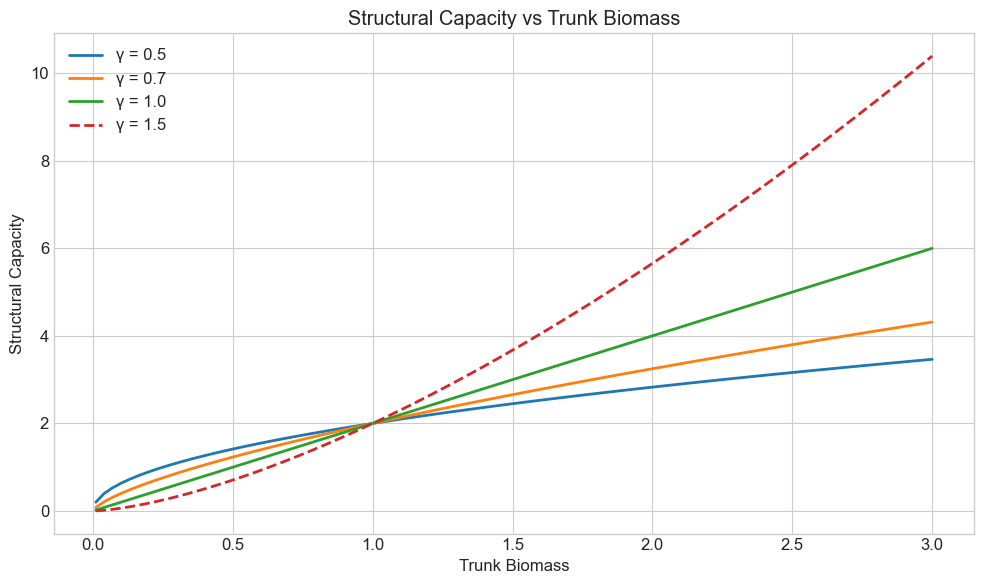

In [8]:
# Vectorized capacity computation
trunk = jnp.linspace(0.01, 3, 100)  # Start at 0.01 to avoid 0^gamma issues

fig, ax = plt.subplots()
for gamma in [0.5, 0.7, 1.0, 1.5]:
    # compute_capacity is already vectorizable
    capacity = surrogates.compute_capacity(trunk, c_trunk=2.0, gamma=gamma)
    style = '-' if gamma <= 1 else '--'
    ax.plot(trunk, capacity, style, label=f'γ = {gamma}', linewidth=2)

ax.set_xlabel('Trunk Biomass')
ax.set_ylabel('Structural Capacity')
ax.set_title('Structural Capacity vs Trunk Biomass')
ax.legend()
plt.tight_layout()
plt.show()

## 8. Composed Gradient Sanity Check

Each surrogate function is smooth in isolation. But when we **multiply** them together for photosynthesis:

$$P = L \cdot P_{max} \cdot f_I(I) \cdot f_W(W) \cdot f_N(N)$$

We can accidentally create "gradient graveyards" where learning dies.

**Failure mode**: If any factor is near zero, the product is near zero and **all** partial derivatives are tiny (product rule). This catches the classic "all my smooth functions multiply into zero" failure.

/var/folders/_0/j0_zkq_d3jn0klz033gq33cc0000gn/T/ipykernel_37071/1471057328.py:91: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/_0/j0_zkq_d3jn0klz033gq33cc0000gn/T/ipykernel_37071/1471057328.py:91: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/nathan/Projects/ndouglas/arborhedron/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nathan/Projects/ndouglas/arborhedron/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


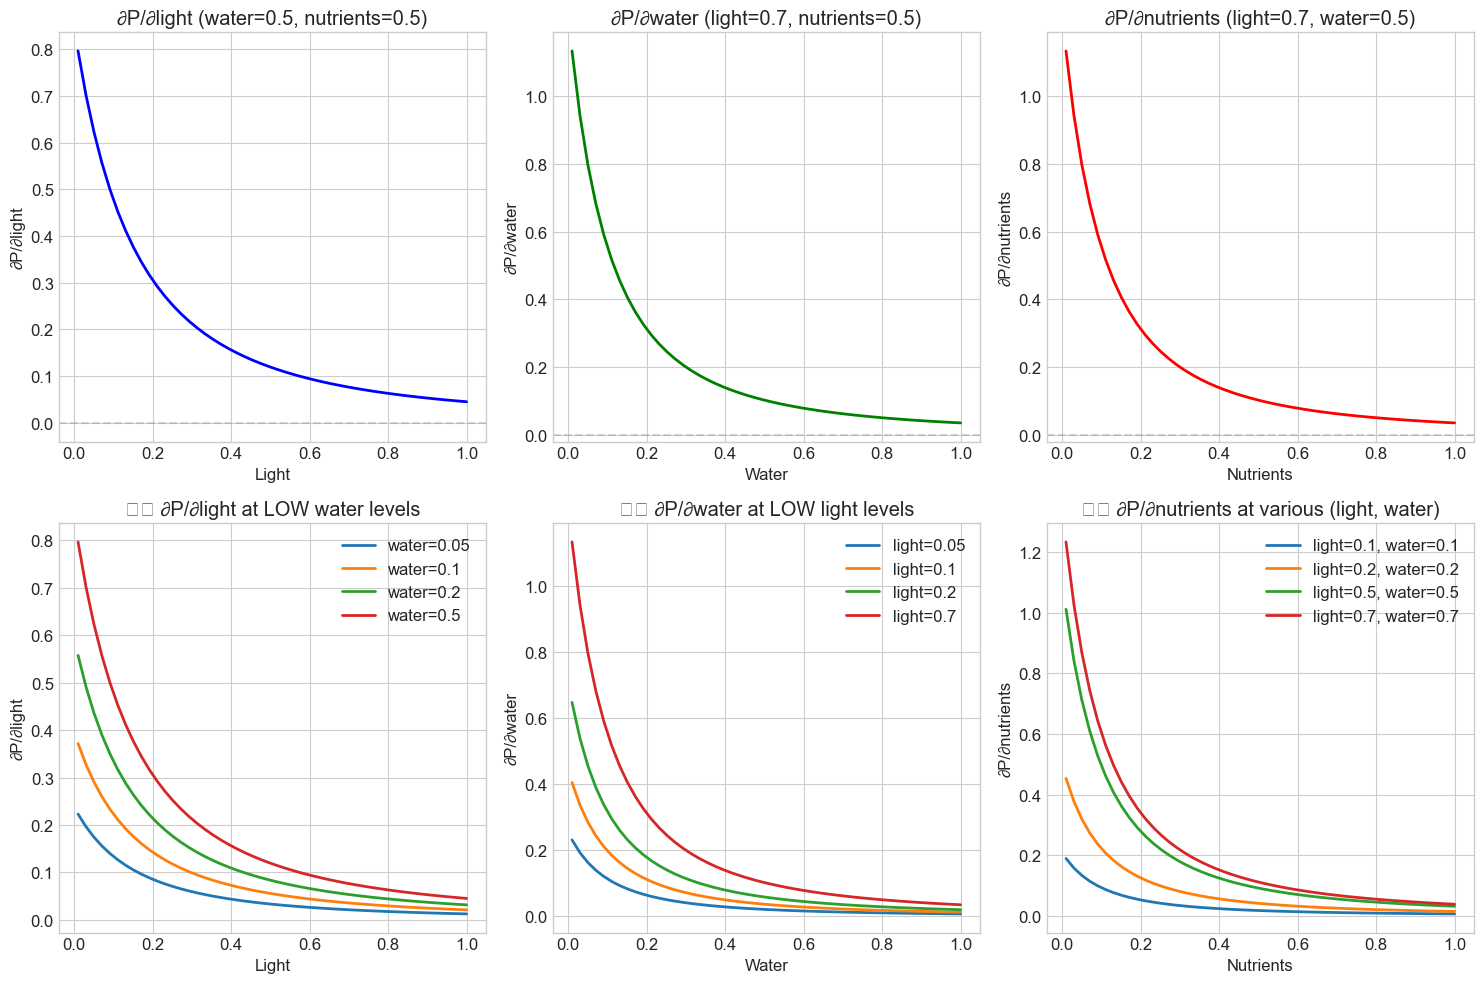


COMPOSED GRADIENT HEALTH CHECK

Condition                    ∂P/∂light    ∂P/∂water  ∂P/∂nutrients
-----------------------------------------------------------------
Very low resources              0.1042       0.0926         0.0926
Low resources                   0.1500       0.1200         0.1200
Moderate resources              0.1196       0.0911         0.0911
High resources                  0.0793       0.0582         0.0582

⚠️  WATCH FOR: Very small gradients at low resources
   If all gradients < 0.01, learning will be very slow.
   Consider: additive terms, curriculum learning, or higher K values.


In [9]:
# Composed gradient analysis for photosynthesis
from jax import grad
import jax

# Define photosynthesis as a function we can differentiate
# IMPORTANT: Don't use float() inside - it breaks JAX tracing!
def photo_fn(light, water, nutrients, leaves=1.0, p_max=0.5, k_light=0.3, k_water=0.2, k_nutrient=0.2):
    """Photosynthesis as a differentiable function."""
    return surrogates.photosynthesis(
        leaves=leaves, light=light, water=water, nutrients=nutrients,
        p_max=p_max, k_light=k_light, k_water=k_water, k_nutrient=k_nutrient
    )

# Get gradients with respect to each input
grad_wrt_light = grad(photo_fn, argnums=0)
grad_wrt_water = grad(photo_fn, argnums=1)
grad_wrt_nutrients = grad(photo_fn, argnums=2)

# Plot gradients across realistic ranges
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Fixed values for the other inputs
fixed_water = 0.5
fixed_nutrients = 0.5
fixed_light = 0.7

# Row 1: Gradients vs each input (holding others fixed at typical values)
light_range = jnp.linspace(0.01, 1.0, 50)
water_range = jnp.linspace(0.01, 1.0, 50)
nutrient_range = jnp.linspace(0.01, 1.0, 50)

# ∂P/∂light
ax = axes[0, 0]
grads = [float(grad_wrt_light(float(l), fixed_water, fixed_nutrients)) for l in light_range]
ax.plot(light_range, grads, 'b-', linewidth=2)
ax.set_xlabel('Light')
ax.set_ylabel('∂P/∂light')
ax.set_title(f'∂P/∂light (water={fixed_water}, nutrients={fixed_nutrients})')
ax.axhline(0, color='gray', linestyle='--', alpha=0.3)

# ∂P/∂water
ax = axes[0, 1]
grads = [float(grad_wrt_water(fixed_light, float(w), fixed_nutrients)) for w in water_range]
ax.plot(water_range, grads, 'g-', linewidth=2)
ax.set_xlabel('Water')
ax.set_ylabel('∂P/∂water')
ax.set_title(f'∂P/∂water (light={fixed_light}, nutrients={fixed_nutrients})')
ax.axhline(0, color='gray', linestyle='--', alpha=0.3)

# ∂P/∂nutrients
ax = axes[0, 2]
grads = [float(grad_wrt_nutrients(fixed_light, fixed_water, float(n))) for n in nutrient_range]
ax.plot(nutrient_range, grads, 'r-', linewidth=2)
ax.set_xlabel('Nutrients')
ax.set_ylabel('∂P/∂nutrients')
ax.set_title(f'∂P/∂nutrients (light={fixed_light}, water={fixed_water})')
ax.axhline(0, color='gray', linestyle='--', alpha=0.3)

# Row 2: Gradient magnitude when OTHER factors are low (the danger zone)
# ∂P/∂light when water is low
ax = axes[1, 0]
for low_water in [0.05, 0.1, 0.2, 0.5]:
    grads = [float(grad_wrt_light(float(l), low_water, fixed_nutrients)) for l in light_range]
    ax.plot(light_range, grads, label=f'water={low_water}', linewidth=2)
ax.set_xlabel('Light')
ax.set_ylabel('∂P/∂light')
ax.set_title('⚠️ ∂P/∂light at LOW water levels')
ax.legend()

# ∂P/∂water when light is low
ax = axes[1, 1]
for low_light in [0.05, 0.1, 0.2, 0.7]:
    grads = [float(grad_wrt_water(low_light, float(w), fixed_nutrients)) for w in water_range]
    ax.plot(water_range, grads, label=f'light={low_light}', linewidth=2)
ax.set_xlabel('Water')
ax.set_ylabel('∂P/∂water')
ax.set_title('⚠️ ∂P/∂water at LOW light levels')
ax.legend()

# ∂P/∂nutrients when both light and water are low (worst case)
ax = axes[1, 2]
conditions = [(0.1, 0.1), (0.2, 0.2), (0.5, 0.5), (0.7, 0.7)]
for light, water in conditions:
    grads = [float(grad_wrt_nutrients(light, water, float(n))) for n in nutrient_range]
    ax.plot(nutrient_range, grads, label=f'light={light}, water={water}', linewidth=2)
ax.set_xlabel('Nutrients')
ax.set_ylabel('∂P/∂nutrients')
ax.set_title('⚠️ ∂P/∂nutrients at various (light, water)')
ax.legend()

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("COMPOSED GRADIENT HEALTH CHECK")
print("="*60)

# Compute gradient magnitude at a few test points
test_points = [
    (0.1, 0.1, 0.1, "Very low resources"),
    (0.3, 0.3, 0.3, "Low resources"),
    (0.5, 0.5, 0.5, "Moderate resources"),
    (0.8, 0.8, 0.8, "High resources"),
]

print(f"\n{'Condition':<25} {'∂P/∂light':>12} {'∂P/∂water':>12} {'∂P/∂nutrients':>14}")
print("-" * 65)
for light, water, nutrients, label in test_points:
    g_light = float(grad_wrt_light(light, water, nutrients))
    g_water = float(grad_wrt_water(light, water, nutrients))
    g_nutrients = float(grad_wrt_nutrients(light, water, nutrients))
    print(f"{label:<25} {g_light:>12.4f} {g_water:>12.4f} {g_nutrients:>14.4f}")

print("\n⚠️  WATCH FOR: Very small gradients at low resources")
print("   If all gradients < 0.01, learning will be very slow.")
print("   Consider: additive terms, curriculum learning, or higher K values.")

## 8. Gradient Health Analysis

All our surrogates saturate by design, which means **gradients vanish in extremes**. Before training, we need to check that our parameter choices don't create "dead zones" where learning can't progress.

Key derivatives:
- **Saturation**: $\frac{d}{dx}\left(\frac{x}{x+K}\right) = \frac{K}{(x+K)^2}$ — peaks at $x=0$, decays as $1/x^2$
- **Sigmoid (wind damage)**: $\frac{d}{dx}\sigma(kx) = k\sigma(kx)(1-\sigma(kx))$ — peaks at $x=0$, width $\propto 1/k$
- **Temperature window**: Product of two sigmoid derivatives

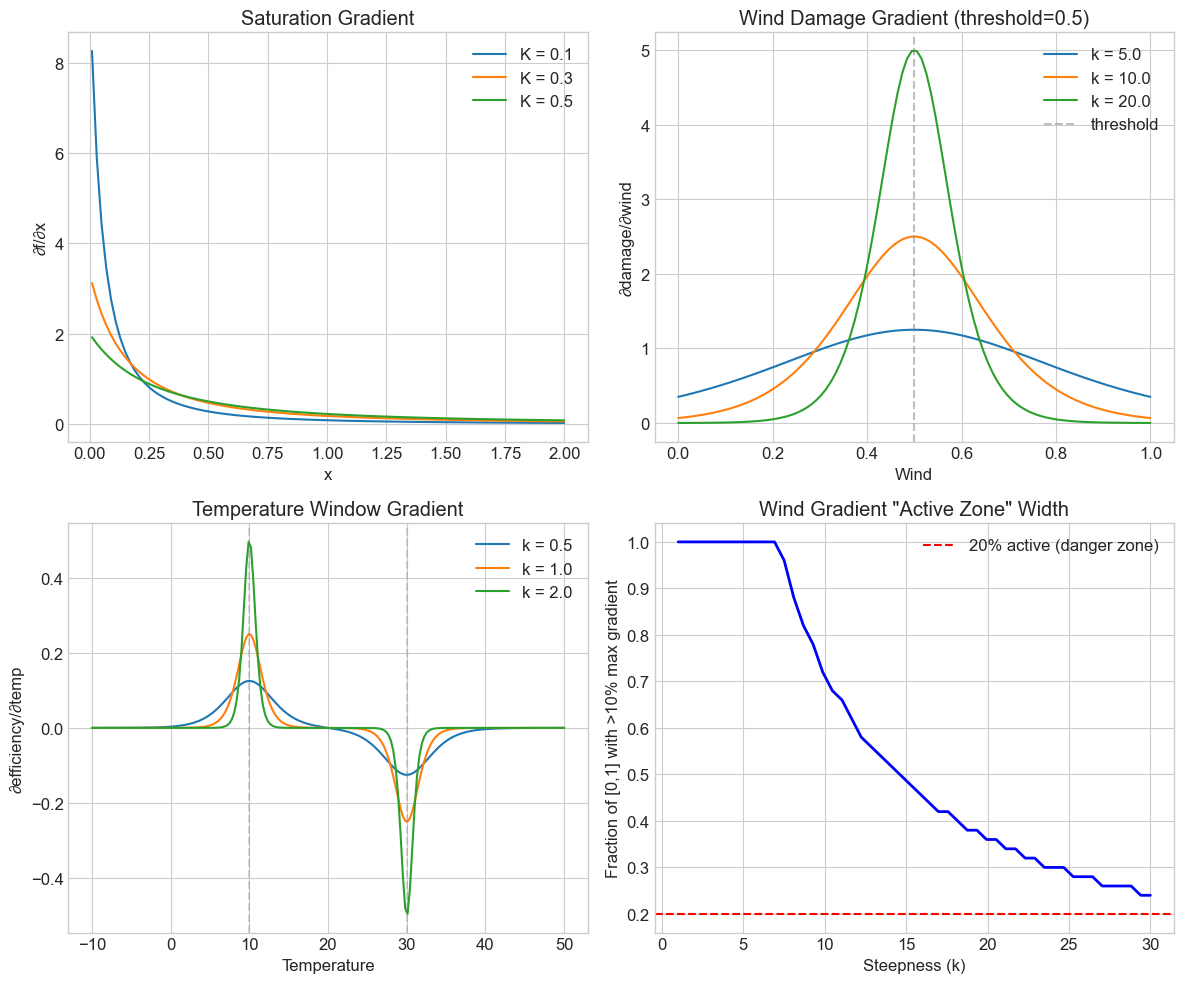


Gradient health check:
  Wind steepness=10 → active zone ≈ 72.0% of [0,1]
  ⚠️  If wind spends most time far from threshold=0.5, gradients will vanish


In [10]:
# Gradient health plots
from jax import grad, vmap

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Saturation gradient (analytical - no autodiff needed)
ax = axes[0, 0]
x = jnp.linspace(0.01, 2, 100)
for k in [0.1, 0.3, 0.5]:
    # Analytical: d/dx [x/(x+k)] = k/(x+k)^2
    grad_sat = k / (x + k)**2
    ax.plot(x, grad_sat, label=f'K = {k}')
ax.set_xlabel('x')
ax.set_ylabel('∂f/∂x')
ax.set_title('Saturation Gradient')
ax.legend()

# 2. Wind damage gradient (analytical sigmoid derivative)
ax = axes[0, 1]
wind = jnp.linspace(0, 1, 100)
threshold = 0.5
for steepness in [5.0, 10.0, 20.0]:
    # Sigmoid derivative: k * σ(z) * (1 - σ(z)) where z = k*(w - threshold)
    z = steepness * (wind - threshold)
    sig = 1 / (1 + jnp.exp(-z))
    grad_wind = steepness * sig * (1 - sig)
    ax.plot(wind, grad_wind, label=f'k = {steepness}')
ax.axvline(0.5, color='gray', linestyle='--', alpha=0.5, label='threshold')
ax.set_xlabel('Wind')
ax.set_ylabel('∂damage/∂wind')
ax.set_title('Wind Damage Gradient (threshold=0.5)')
ax.legend()

# 3. Temperature window gradient (analytical double sigmoid)
ax = axes[1, 0]
temps = jnp.linspace(-10, 50, 200)
t_min, t_max = 10, 30
for steepness in [0.5, 1.0, 2.0]:
    # f(T) = σ(k(T-Tmin)) * σ(k(Tmax-T))
    # f'(T) = σ'_low * σ_high + σ_low * σ'_high
    z_low = steepness * (temps - t_min)
    z_high = steepness * (t_max - temps)
    sig_low = 1 / (1 + jnp.exp(-z_low))
    sig_high = 1 / (1 + jnp.exp(-z_high))
    dsig_low = steepness * sig_low * (1 - sig_low)
    dsig_high = -steepness * sig_high * (1 - sig_high)  # Negative because of (Tmax - T)
    grad_temp = dsig_low * sig_high + sig_low * dsig_high
    ax.plot(temps, grad_temp, label=f'k = {steepness}')
ax.axvline(10, color='gray', linestyle='--', alpha=0.3)
ax.axvline(30, color='gray', linestyle='--', alpha=0.3)
ax.set_xlabel('Temperature')
ax.set_ylabel('∂efficiency/∂temp')
ax.set_title('Temperature Window Gradient')
ax.legend()

# 4. Gradient "dead zone" analysis for wind
ax = axes[1, 1]
steepnesses = jnp.linspace(1, 30, 50)
wind_range = jnp.linspace(0, 1, 100)

active_fractions = []
for k in steepnesses:
    z = float(k) * (wind_range - 0.5)
    sig = 1 / (1 + jnp.exp(-z))
    grad_mag = float(k) * sig * (1 - sig)
    # Count fraction where gradient > 0.1 * max
    active = jnp.mean(grad_mag > 0.1 * jnp.max(grad_mag))
    active_fractions.append(float(active))

ax.plot(steepnesses, active_fractions, 'b-', linewidth=2)
ax.axhline(0.2, color='r', linestyle='--', label='20% active (danger zone)')
ax.set_xlabel('Steepness (k)')
ax.set_ylabel('Fraction of [0,1] with >10% max gradient')
ax.set_title('Wind Gradient "Active Zone" Width')
ax.legend()

plt.tight_layout()
plt.show()

print("\nGradient health check:")
print(f"  Wind steepness=10 → active zone ≈ {active_fractions[15]:.1%} of [0,1]")
print(f"  ⚠️  If wind spends most time far from threshold=0.5, gradients will vanish")